# Comparing global LoCuSS High-$L_{\rm{X}}$ $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements to literature

This notebook measures global temperatures and luminosities for the LoCuSS sample, then compares them to the measurements from literature. While the focus of this work is the measurement of galaxy cluster masses, temperatures and luminosities play an important role in the construction of X-ray mass-observable scaling relations - thus they must also be shown to be consistent with previous work. 

It is important to note that two values for $R_{500}$ are available for the LoCuSS High-$L_{\rm{X}}$ sample, the Martino et al. values within which gas and hydrostatic masses are measured, and the weak-lensing measured $R_{500}$s used in the Mulroy et al. work from which we take temperatures and luminosities. 

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 90
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sources import GalaxyCluster
from xga.sources import BaseSource
from xga.xspec import single_temp_apec
from xga.relations.fit import scaling_relation_odr
from xga.models.misc import power_law

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

## Reading LoCuSS file and declaring a cluster sample

This subsection involves reading in the sample files of the LoCuSS test sample (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 45/45 [03:39<00:00,  4.89s/it]


## Comparing different values of $R_{500}$

Two values for $R_{500}$ are available for the LoCuSS High-$L_{\rm{X}}$ sample, the Martino et al. values within which gas and hydrostatic masses are measured, and the weak-lensing measured $R_{500}$ values used in the Mulroy et al. work from which we take temperatures and luminosities. 

Here we illustrate the scatter between the two measurements. The comparison follows the one-to-one line, but there are some significant differences in radius.

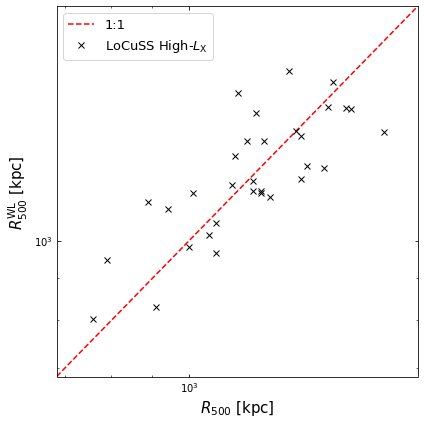

In [4]:
direct_comparison_plot(Quantity(locuss['r500'], 'kpc'), Quantity(locuss['r500wl'], 'kpc'), r'$R_{500}$ [kpc]', 
                       r'$R^{\rm{WL}}_{500}$ [kpc]', r'LoCuSS High-$L_{\rm{X}}$', (6, 6))

## Reading temperatures, luminosities, and radii from the sample file

### Weak lensing $R_{500}$

As XGA requires that each source has a radius entry when spectra generation and XSPEC fitting is undertaken, we shall create an array where any cluster without a WL radius instead has its Martino et al. radius substituted. By keeping track of the clusters in our sample which do not have a WL radius, we can ignore those results at the end.

In [5]:
# Will store the weak lensing radii, although any source that doesn't have a weak lensing radius will have its
#  Martino et al. radius substituted - this is because XGA doesn't like missing radii
wl_rads = []
# A mask so we can easily recover which clusters do have weak lensing radii
with_wl = []

# Iterating through clusters in our XGA sample
for src in locuss_srcs:
    # Finding the relevant line in the sample file for this current source
    rel_info = locuss[locuss['name'] == src.name].iloc[0]
    # Is there an entry for weak lensing R500?
    if np.isnan(rel_info['r500wl']):
        wl_rads.append(src.r500)
        with_wl.append(False)
    else:
        wl_rads.append(Quantity(rel_info['r500wl'], 'kpc'))
        with_wl.append(True)
        
wl_rads = Quantity(wl_rads)
with_wl = np.array(with_wl)

### Literature values of $T_{\rm{X}}$ and $L_{\rm{X}}$

In [6]:
loclit_tx = []
loclit_lxbol = []
for n in locuss_srcs.names:
    rel_row = locuss[locuss['name'] == n].iloc[0]
    loclit_tx.append(Quantity(rel_row[['x_Tx500ce', 'x_Tx500ce-', 'x_Tx500ce+']], 'keV'))
    loclit_lxbol.append(Quantity(rel_row[['x_Lxbol', 'x_Lxbol_err', 'x_Lxbol_err']]*1e+44, 'erg/s'))
    
loclit_tx = Quantity(loclit_tx)
loclit_lxbol = Quantity(loclit_lxbol)

## Running $T_{\rm{X}}$ and $L_{\rm{X}}$ Measurements

The XGA XSPEC functions that we use here all automatically call the XGA SAS interface, so the necessary spectra are generated before the fits begin. As the different samples measure properties within different spatial regions, all the function calls differ slightly.

The results of the fits are stored within the individual source objects that make up each sample.

### Using Martino et al. $R_{500}$

The LoCuSS temperatures and luminosities are slightly different, and have been measured with the core of the X-ray emission removed (spectra are generated in the 0.15-1 $R_{500}$ region). This approach has been shown to reduce the scatter in mass with $L_{\rm{X}}$. We can replicate it by setting an inner radius when we call `single_temp_apec`.

We first measure these properties within $R_{500}$ values presented in Martino et al., which were derived from a $Y_{\rm{X}}$-$r$ scaling relation - these radii **WERE NOT** used for the measurement of temperatures and luminosities in literature that we will compare to, but we analyse them so we can present new measurements of temperature for the clusters which have been observed with XMM since the original analysis (not every cluster has a WL radius):

In [7]:
single_temp_apec(locuss_srcs, locuss_srcs.r500, inner_radius=0.15*locuss_srcs.r500, lo_en=Quantity(0.7, 'keV'), 
                 hi_en=Quantity(10, 'keV'), freeze_met=False, timeout=timeout, one_rmf=False)
single_temp_apec(locuss_srcs, locuss_srcs.r500, lo_en=Quantity(0.7, 'keV'), hi_en=Quantity(10, 'keV'), 
                 freeze_met=False, timeout=timeout, one_rmf=False)

### Using Mulroy et al. weak lensing $R_{500}$

These are the apertures used for the temperatures and luminosities that we shall compare to - though we do not have access to weak lensing radii for all of the LoCuSS clusters. 

In [8]:
single_temp_apec(locuss_srcs, wl_rads, inner_radius=0.15*wl_rads, lo_en=Quantity(0.7, 'keV'), 
                 hi_en=Quantity(10, 'keV'), freeze_met=False, timeout=timeout, one_rmf=False)
single_temp_apec(locuss_srcs, wl_rads, lo_en=Quantity(0.7, 'keV'), hi_en=Quantity(10, 'keV'), 
                 freeze_met=False, timeout=timeout, one_rmf=False)

## Retrieving $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements from the samples

We must extract and judge the quality of the temperature and luminosity measurements that we have made for each of the samples, then later on we will be able to directly compare them. At the same time we make sure that the results from literature are formatted in such a way that we can easily compare them.

### Martino et al.

In [9]:
locuss_txce = locuss_srcs.Tx(locuss_srcs.r500, inner_radius=0.15*locuss_srcs.r500, quality_checks=False)
locuss_lx52ce = locuss_srcs.Lx(locuss_srcs.r500, inner_radius=0.15*locuss_srcs.r500, quality_checks=False, 
                                    lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
locuss_lxbolce = locuss_srcs.Lx(locuss_srcs.r500, inner_radius=0.15*locuss_srcs.r500, quality_checks=False, 
                                    lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))

locuss_tx = locuss_srcs.Tx(locuss_srcs.r500, quality_checks=False)
locuss_lx52 = locuss_srcs.Lx(locuss_srcs.r500, quality_checks=False, lo_en=Quantity(0.5, 'keV'), 
                             hi_en=Quantity(2.0, 'keV'))
locuss_lxbol = locuss_srcs.Lx(locuss_srcs.r500, quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                                  hi_en=Quantity(100.0, 'keV'))

### Mulroy et al. (WL)

In [10]:
wl_locuss_txce = locuss_srcs.Tx(wl_rads, inner_radius=0.15*wl_rads, quality_checks=False)
wl_locuss_txce[~with_wl] = Quantity([np.NaN, np.NaN, np.NaN], 'keV')

wl_locuss_lx52ce = locuss_srcs.Lx(wl_rads, inner_radius=0.15*wl_rads, quality_checks=False, 
                                lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
wl_locuss_lx52ce[~with_wl] = Quantity([np.NaN, np.NaN, np.NaN], 'erg/s')

wl_locuss_lxbolce = locuss_srcs.Lx(wl_rads, inner_radius=0.15*wl_rads, quality_checks=False, 
                                       lo_en=Quantity(0.01, 'keV'), hi_en=Quantity(100.0, 'keV'))
wl_locuss_lxbolce[~with_wl] = Quantity([np.NaN, np.NaN, np.NaN], 'erg/s')


wl_locuss_tx = locuss_srcs.Tx(wl_rads, quality_checks=False)
wl_locuss_tx[~with_wl] = Quantity([np.NaN, np.NaN, np.NaN], 'keV')

wl_locuss_lx52 = locuss_srcs.Lx(wl_rads, quality_checks=False, lo_en=Quantity(0.5, 'keV'), 
                                     hi_en=Quantity(2.0, 'keV'))
wl_locuss_lx52[~with_wl] = Quantity([np.NaN, np.NaN, np.NaN], 'erg/s')

wl_locuss_lxbol = locuss_srcs.Lx(wl_rads, quality_checks=False, lo_en=Quantity(0.01, 'keV'), 
                                     hi_en=Quantity(100.0, 'keV'))
wl_locuss_lxbol[~with_wl] = Quantity([np.NaN, np.NaN, np.NaN], 'erg/s')

## Direct comparisons between original and XGA measurements

This is the the point of this notebook, making direct comparisons of like for like (or as near as we can achieve) measurements from literature to measurements made using XGA. In each case we plot simple one-to-one comparisons, with a one-to-one dashed line in red to give a reference.

We directly compare temperatures and luminosities measured by LoCuSS - specifically those measured by XMM; LoCuSS used both XMM and Chandra. We have measured more XMM $T_{\rm{X}}$ and $L_{\rm{X}}$ values for the LoCuSS sample than were originally measured, most likely due to the several years of extra data that we have access to. 

In [11]:
print('There were {n} LoCuSS temperatures originally from Graham'.format(n=np.isfinite(loclit_tx[:, 0]).sum()))

There were 31 LoCuSS temperatures originally from Graham


### Martino et al radii - $T_{\rm{X}, 500ce}$ and $L^{\rm{bol}}_{\rm{X}, 500}$

Measuring properties within the Martino et al. $R_{500}$ values, derived from an R-$Y_{\rm{X}}$ relation:

In [12]:
print('{s} out of {t} XGA Txce measurements were successful'.format(s=np.isfinite(locuss_txce[:, 0]).sum(), 
                                                                  t=len(locuss_txce)))
print('{s} out of {t} XGA Lxbolce measurements were successful'.format(s=np.isfinite(locuss_lxbol[:, 0]).sum(), 
                                                                    t=len(locuss_lxbol)))

45 out of 45 XGA Txce measurements were successful
45 out of 45 XGA Lxbolce measurements were successful


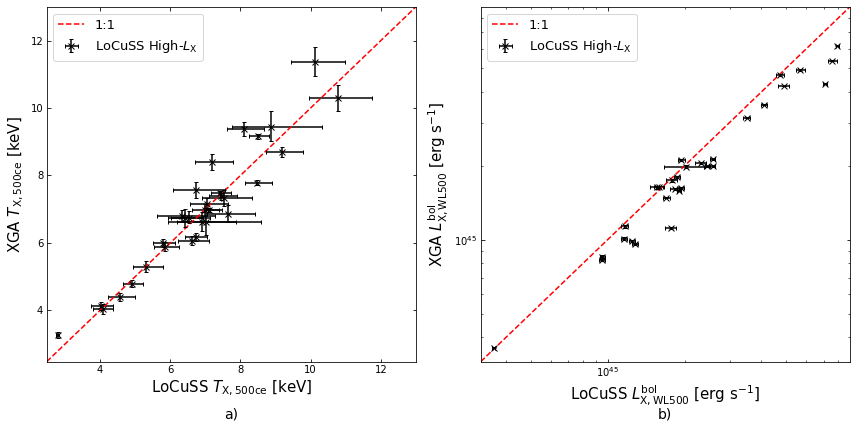

In [13]:
direct_comparison_plot([loclit_tx, loclit_lxbol], [locuss_txce, locuss_lxbol], 
                       [r"LoCuSS $T_{\rm{X, 500ce}}$ [keV]", 
                        r"LoCuSS $L^{\rm{bol}}_{\rm{X, WL500}}$ [erg s$^{-1}$]"], 
                       [r"XGA $T_{\rm{X, 500ce}}$ [keV]", r"XGA $L^{\rm{bol}}_{\rm{X, WL500}}$ [erg s$^{-1}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['linear', 'log'], ['linear', 'log'])

100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:17<00:00, 1117.75it/s]


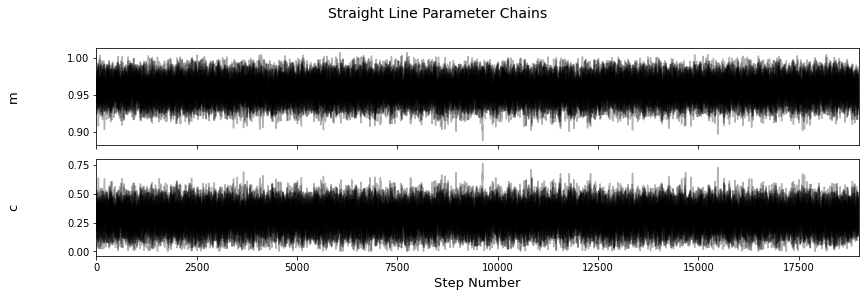

Removed no burn in


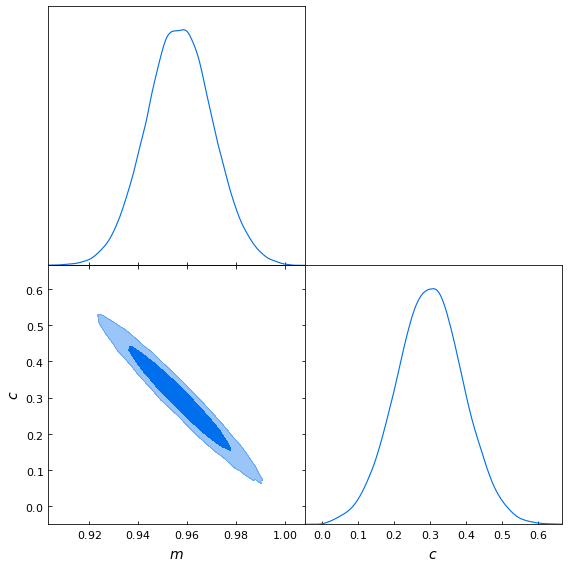

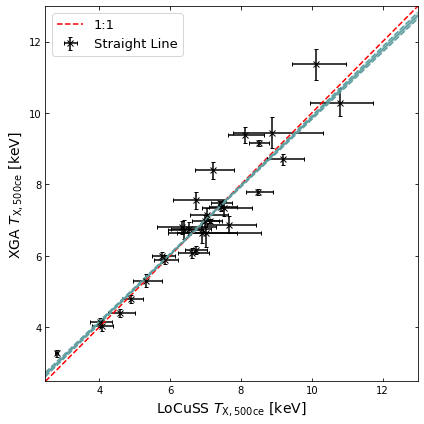

m=0.957 +0.014 -0.014 [1sig]
c=0.299 +0.093 -0.094 [1sig]


In [14]:
fit_comp(loclit_tx, locuss_txce, [[0, 100], [0, 5]], r"LoCuSS $T_{\rm{X, 500ce}}$ [keV]", 
         r"XGA $T_{\rm{X, 500ce}}$ [keV]", Quantity(1, 'keV'),  num_steps=20000, view_chains=True, 
         linear=True, view_corner=True)
# fit_comp(loclit_tx, locuss_txce, [[0, 100], [0, 5]], num_steps=10000, view_chains=False)

### Mulroy et al. radii (WL) - $T_{\rm{X}, 500ce}$ and $L^{\rm{bol}}_{\rm{X}, 500}$

In [15]:
print('{s} out of {t} XGA Txce measurements were successful'.format(s=np.isfinite(wl_locuss_txce[:, 0]).sum(), 
                                                                  t=len(wl_locuss_txce[with_wl])))
print('{s} out of {t} XGA Lxbolce measurements were successful'.format(s=np.isfinite(wl_locuss_lxbol[:, 0]).sum(), 
                                                                    t=len(wl_locuss_lxbol[with_wl])))

31 out of 31 XGA Txce measurements were successful
31 out of 31 XGA Lxbolce measurements were successful


A comparison made between the values measured within radii derived from weak lensing analysis:

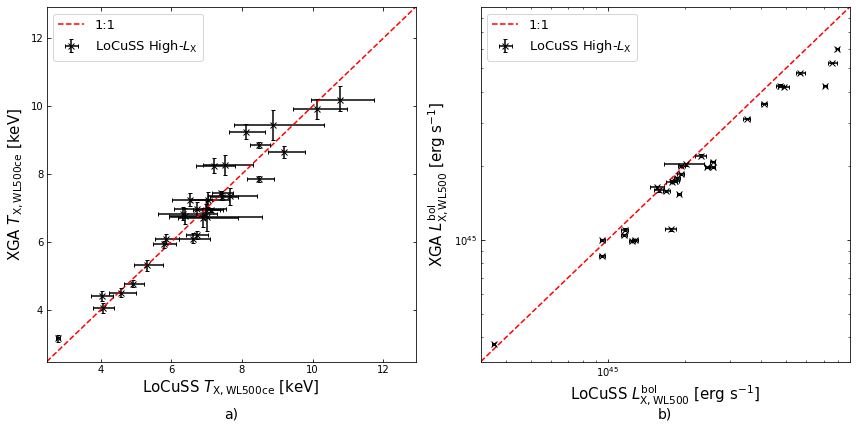

In [16]:
direct_comparison_plot([loclit_tx, loclit_lxbol], [wl_locuss_txce, wl_locuss_lxbol], 
                       [r"LoCuSS $T_{\rm{X, WL500ce}}$ [keV]", 
                        r"LoCuSS $L^{\rm{bol}}_{\rm{X, WL500}}$ [erg s$^{-1}$]"], 
                       [r"XGA $T_{\rm{X, WL500ce}}$ [keV]", r"XGA $L^{\rm{bol}}_{\rm{X, WL500}}$ [erg s$^{-1}$]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['linear', 'log'], ['linear', 'log'])

100%|█████████████████████████████████████████████████████████████████| 20000/20000 [00:18<00:00, 1104.64it/s]


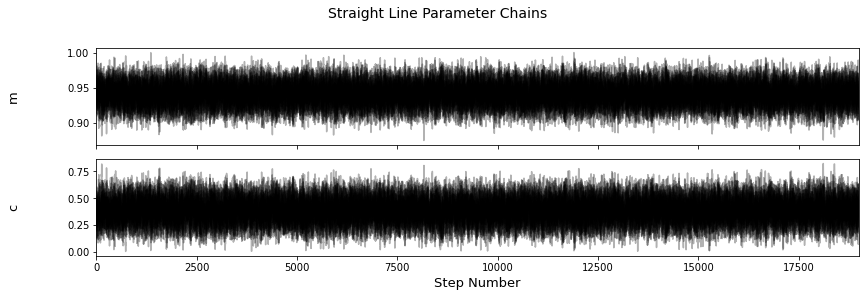

Removed no burn in


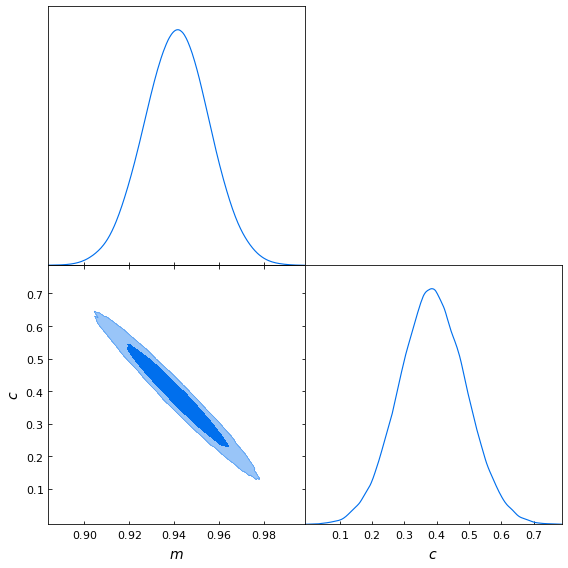

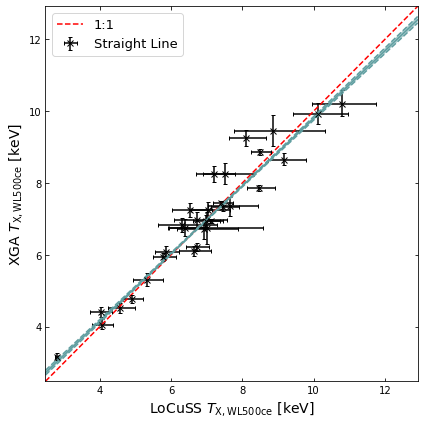

m=0.941 +0.015 -0.015 [1sig]
c=0.386 +0.104 -0.102 [1sig]


In [17]:
fit_comp(loclit_tx, wl_locuss_txce, [[0, 100], [0, 5]], r"LoCuSS $T_{\rm{X, WL500ce}}$ [keV]", 
         r"XGA $T_{\rm{X, WL500ce}}$ [keV]", Quantity(1, 'keV'),  num_steps=20000, view_chains=True, 
         linear=True, view_corner=True)


### 

### $T_{\rm{X}}$ values for both radii sets

Nothing new is shown here, just showing the temperature comparisons of both measured sets of temperatures here:

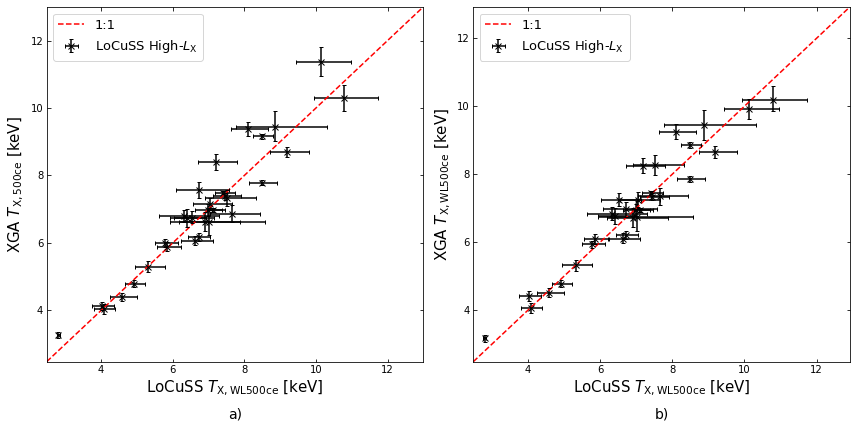

In [21]:
direct_comparison_plot([loclit_tx, loclit_tx], [locuss_txce, wl_locuss_txce], 
                       [r"LoCuSS $T_{\rm{X, WL500ce}}$ [keV]", 
                        r"LoCuSS $T_{\rm{X, WL500ce}}$ [keV]"], 
                       [r"XGA $T_{\rm{X, 500ce}}$ [keV]", r"XGA $T_{\rm{X, WL500ce}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['linear', 'linear'], ['linear', 'linear'], 
                       savepath='../../outputs/figures/locuss_Tx500ce_Tx500wlce_comp.pdf')


## New XMM $T_{\rm{X}}$ and $L_{\rm{X}}$ measurements for LoCuSS clusters

This ugly luminosity-temperature scaling relation illustrates which of the values had no XMM counterpart in the original LoCuSS measurements; points with a colour value attributed to '1' are newly measured.

All values in this scaling relation are measured with XGA:

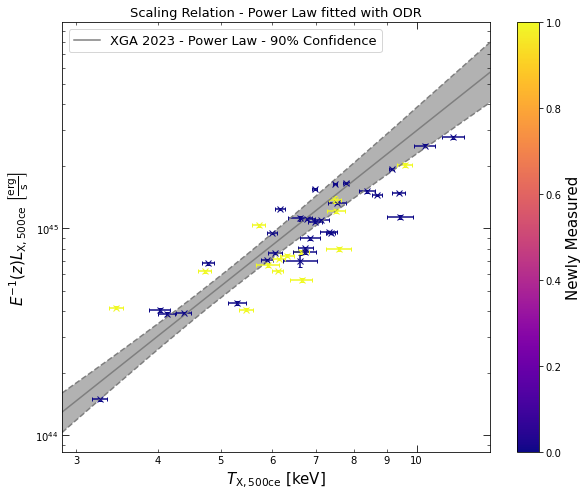

In [19]:
new_or_not = np.zeros(len(loclit_tx))
new_meas_inds = np.array(list(set(np.where(np.isnan(loclit_tx))[0])))
new_or_not[new_meas_inds] = 1

ez_scaled_lx = locuss_lxbolce * locuss_srcs.cosmo.inv_efunc(locuss_srcs.redshifts)[..., None]

lxtx = scaling_relation_odr(power_law, ez_scaled_lx[:, 0], ez_scaled_lx[:, 1:], locuss_txce[:, 0], 
                            locuss_txce[:, 1:], Quantity(1e+45, 'erg/s'), Quantity(5, 'keV'), 
                            y_name=r'$E^{-1}(z) L_{\rm{X, 500ce}}$', x_name=r'$T_{\rm{X, 500ce}}$', 
                            third_dim_info=new_or_not, third_dim_name='Newly Measured')
lxtx.view(figsize=(8.5, 7))

## Outputting XGA measured values as a catalogue

We want to save our XGA measurements of temperature and luminosity to a file, so that we can access them later:

In [20]:
xga_res_r500 = pd.DataFrame(np.array([locuss_srcs.names.T, locuss_tx[:, 0].value, locuss_tx[:, 1].value, 
                                      locuss_tx[:, 2].value, locuss_lx52[:, 0].value, locuss_lx52[:, 1].value, 
                                      locuss_lx52[:, 2].value, locuss_lxbol[:, 0].value, locuss_lxbol[:, 1].value, 
                                      locuss_lxbol[:, 2].value, 
                                      locuss_txce[:, 0].value, locuss_txce[:, 1].value, 
                                      locuss_txce[:, 2].value, locuss_lx52ce[:, 0].value, locuss_lx52ce[:, 1].value, 
                                      locuss_lx52ce[:, 2].value, locuss_lxbolce[:, 0].value, 
                                      locuss_lxbolce[:, 1].value, locuss_lxbolce[:, 2].value]).T, 
                            columns=['name', 'Tx_500', 'Tx_500-', 'Tx_500+', 'Lx52_500', 'Lx52_500-', 
                                     'Lx52_500+', 'Lxbol_500', 'Lxbol_500-', 'Lxbol_500+', 
                                     'Tx_500ce', 'Tx_500ce-', 'Tx_500ce+', 'Lx52_500ce', 'Lx52_500ce-', 
                                     'Lx52_500ce+', 'Lxbol_500ce', 'Lxbol_500ce-', 'Lxbol_500ce+'])


xga_res_r500wl = pd.DataFrame(np.array([locuss_srcs.names.T, wl_locuss_tx[:, 0].value, wl_locuss_tx[:, 1].value, 
                                        wl_locuss_tx[:, 2].value, wl_locuss_lx52[:, 0].value, 
                                        wl_locuss_lx52[:, 1].value, wl_locuss_lx52[:, 2].value, 
                                        wl_locuss_lxbol[:, 0].value, wl_locuss_lxbol[:, 1].value, 
                                        wl_locuss_lxbol[:, 2].value, 
                                        wl_locuss_txce[:, 0].value, wl_locuss_txce[:, 1].value, 
                                        wl_locuss_txce[:, 2].value, wl_locuss_lx52ce[:, 0].value, 
                                        wl_locuss_lx52ce[:, 1].value, wl_locuss_lx52ce[:, 2].value, 
                                        wl_locuss_lxbolce[:, 0].value, wl_locuss_lxbolce[:, 1].value, 
                                        wl_locuss_lxbolce[:, 2].value]).T, 
                              columns=['name', 'Tx_500wl', 'Tx_500wl-', 'Tx_500wl+', 'Lx52_500wl', 'Lx52_500wl-', 
                                       'Lx52_500wl+', 'Lxbol_500wl', 'Lxbol_500wl-', 'Lxbol_500wl+', 
                                       'Tx_500wlce', 'Tx_500wlce-', 'Tx_500wlce+', 'Lx52_500wlce', 'Lx52_500wlce-', 
                                       'Lx52_500wlce+', 'Lxbol_500wlce', 'Lxbol_500wlce-', 'Lxbol_500wlce+'])

xga_locuss_out = pd.merge(xga_res_r500, xga_res_r500wl, on='name', how='left')
xga_locuss_out.to_csv("../../outputs/results/locuss_txlx.csv", index=False)

xga_locuss_out

,name,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,Lx52_500+,Lxbol_500,Lxbol_500-,Lxbol_500+,...,Lxbol_500wl+,Tx_500wlce,Tx_500wlce-,Tx_500wlce+,Lx52_500wlce,Lx52_500wlce-,Lx52_500wlce+,Lxbol_500wlce,Lxbol_500wlce-,Lxbol_500wlce+
0,Abell2697,7.01871,0.1234223989999998,0.12379373,4.661682687e+44,2.5624159326180503e+42,2.6563573337057903e+42,1.7984137170000003e+45,1.4282836672637662e+43,1.398053941365968e+43,...,1.790656751209211e+43,6.9397,0.1726884780000004,0.1673231749999999,3.1495115420000003e+44,2.4335344803405502e+42,2.4883716222567303e+42,1.2063790390000001e+45,1.38181855765468e+43,1.2545154020503673e+43
1,Abell0068,7.32519,0.1926928239999998,0.1904899879999995,4.150675149e+44,2.97794022524726e+42,3.632381119336671e+42,1.635794747e+45,1.7928986061809762e+43,2.2879830024251494e+43,...,2.0890872982491523e+43,7.35102,0.2638221070000002,0.2526811970000002,2.710065577e+44,2.7255449319006503e+42,2.80077845767262e+42,1.0653395500000002e+45,1.653298042137563e+43,1.5720614881045813e+43
2,Abell2813,7.00377,0.1423327009999999,0.1427598599999999,5.139554402e+44,5.234534669143811e+42,6.290033145376871e+42,1.9856951250000004e+45,2.230968670316723e+43,2.720240242112317e+43,...,2.77921626779444e+43,6.83016,0.1838062489999998,0.1988757319999994,3.3762914340000005e+44,4.0653654341533704e+42,6.854008003448411e+42,1.2839406580000001e+45,2.3841324627987055e+43,2.9870496554785593e+43
3,Abell0115S,5.88177,0.1188634720000001,0.119463176,2.42503636e+44,1.6662372437982802e+42,1.7166751932443702e+42,8.536056558000001e+44,8.256294207607261e+42,8.859149507758731e+42,...,1.1683451392339641e+43,6.08045,0.1334050900000001,0.1532900560000003,2.4269673930000003e+44,1.71434619751264e+42,1.7331289478670203e+42,8.715254633000002e+44,9.11597474436786e+42,8.993060870721701e+42
4,Abell141,5.81341,0.1357010890000003,0.1250489999999997,3.6795744830000005e+44,2.68893220421247e+42,2.5983468051754102e+42,1.2911398950000001e+45,1.356398436401296e+43,1.3342456374444972e+43,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,ZwCl0104.4+0048,3.11124,0.0386612699999999,0.0387508599999999,3.921749619e+44,2.7318982633835802e+42,3.0194740337677506e+42,1.029118782e+45,6.74079508965758e+42,8.19852409532116e+42,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,Abell0209,6.90149,0.1423488869999998,0.1403966260000002,4.25936092e+44,2.18666687931573e+42,3.00622463611061e+42,1.629815609e+45,1.8430363845372812e+43,1.457377571352843e+43,...,1.5275668813934023e+43,7.23738,0.1934089400000003,0.2273210829999996,3.2706853900000005e+44,3.9060446072146806e+42,2.3590081542855002e+42,1.27494415e+45,1.4341490204755252e+43,1.6729440894139663e+43
7,Abell0267,6.05075,0.1606229059999995,0.18124683,3.4075147410000004e+44,3.197570418799111e+42,3.18393550719772e+42,1.2261921140000002e+45,1.6331814037302862e+43,1.532250712670007e+43,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,Abell0291,3.66694,0.057164594,0.0577248420000002,2.9262404970000003e+44,1.9308596365063404e+42,2.3555776354527e+42,8.281925191e+44,6.466238883591411e+42,8.30629514058211e+42,...,7.782216757022791e+42,4.40827,0.1492554400000001,0.1524575940000003,1.347126339e+44,2.1556220490048e+42,1.89833394244967e+42,4.138180447e+44,8.856487006800771e+42,9.447930004527081e+42
9,Abell0383,4.01528,0.0462996849999997,0.0462378560000003,3.2424133450000003e+44,1.3662597534650902e+42,1.8142259849532603e+42,9.569060455000002e+44,8.55118506590664e+42,5.98196912685374e+42,...,6.78024750561231e+42,4.51297,0.1281371,0.135862092,1.3515166800000002e+44,1.5875360568918e+42,1.2217835516561001e+42,4.195720096e+44,7.389364696947911e+42,6.36211916358698e+42
